In [28]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from tqdm import trange

In [2]:
dirpath="./drive/MyDrive/test.png"

In [48]:
class remodel(nn.Module):
  def __init__(self):
    super(remodel,self).__init__()
    self.layer1=nn.Conv2d(3,5,20,4)
    self.layer2=nn.Conv2d(5,3,10,4)
    self.relu=nn.ReLU()
    self.linear1=nn.Linear(3*19*17,1024)
    self.linear2=nn.Linear(1024,320*350*3)
  def forward(self, x):
    input=x.transpose(0,2)
    mid1=self.layer1(input)
    mid2=self.relu(mid1)
    mid3=self.layer2(mid2)
    mid4=self.relu(mid3)
    mid5=mid4.reshape(1,3*19*17)
    mid6=self.linear1(mid5)
    mid7=self.relu(mid6)
    mid8=self.linear2(mid7)
    return 10*torch.abs(mid8)

In [49]:
def loss(output,true_output):
  output=output.to(device)
  mid=(output-true_output)**2
  end=mid.mean()
  return end

In [50]:
add_noise=remodel()

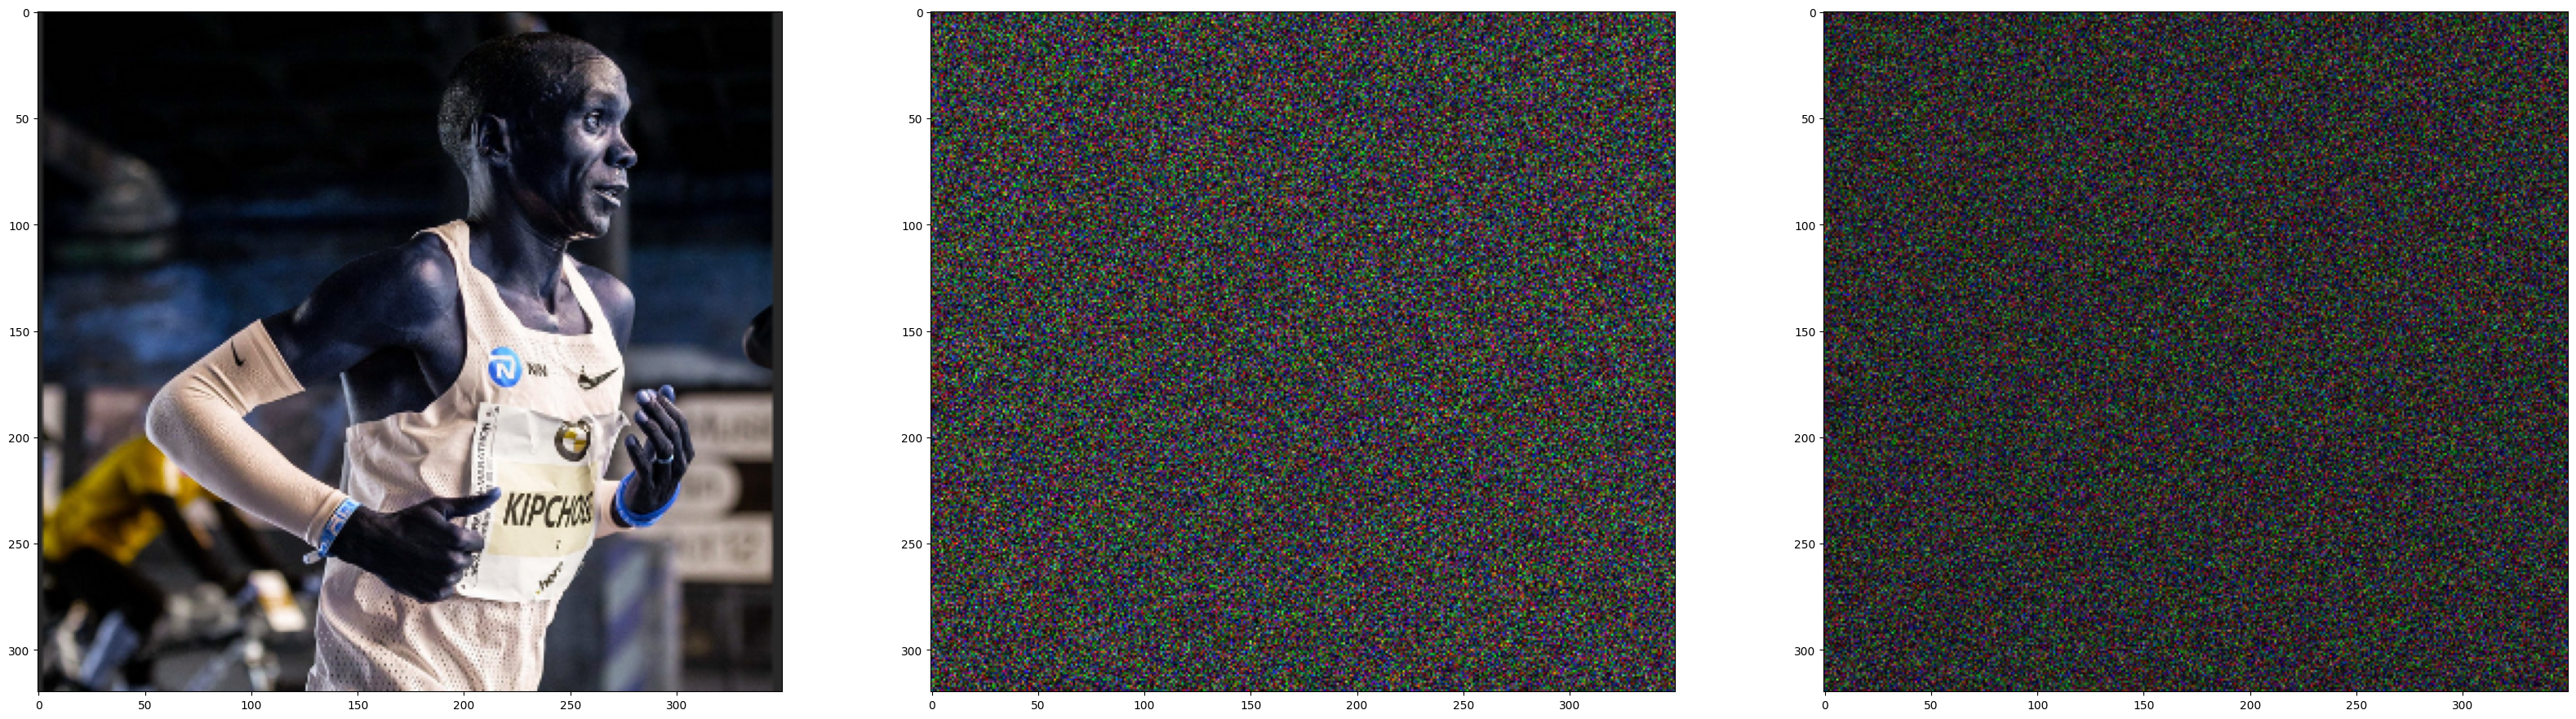

In [51]:
device=torch.device("cuda:0"if torch.cuda.is_available()else "cpu")
img=cv2.imread(dirpath)
front=[]
plt.figure(figsize=(40, 20))
input=torch.Tensor(img)
front.append(input)
num_step=2
for i in range(num_step):
  input=add_noise(input)
  input=input.reshape(320,350,3).detach()
  front.append(input.detach())
for i in range(len(front)):
  plt.subplot(1,len(front),i+1)
  plt.imshow(front[i].numpy().astype(np.int32))
plt.show()

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir "./drive/MyDrive/log/"

In [82]:
learn_rating=1e-4
step=40000
back=[remodel() for i in range(len(front)-1)]
for i in range(len(back)):
  back[i]=back[i].to(device)
optimizer=[torch.optim.SGD(back[i].parameters(),lr=learn_rating,momentum=0.9) for i in range(len(front)-1)]
jishu=-1

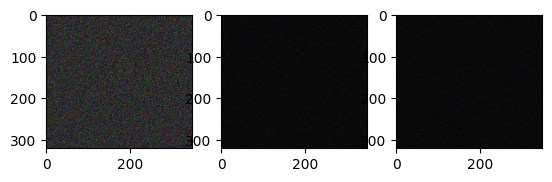

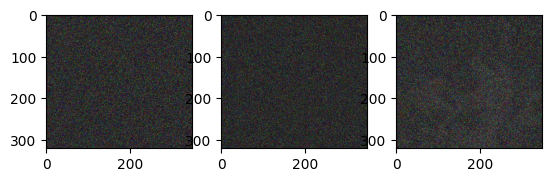

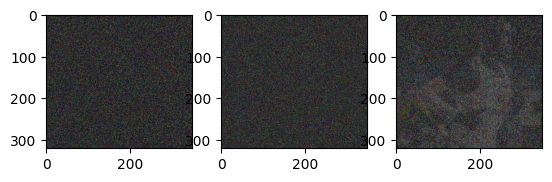

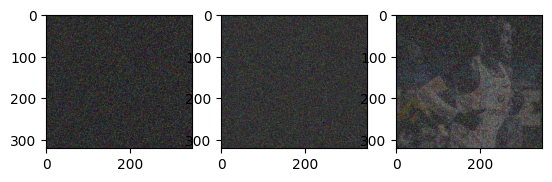

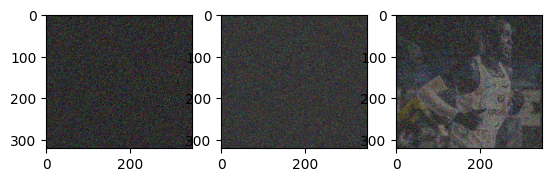

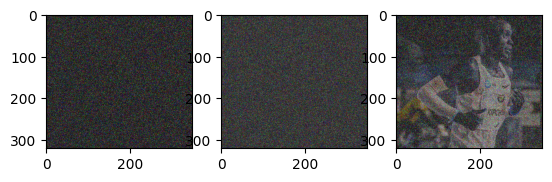

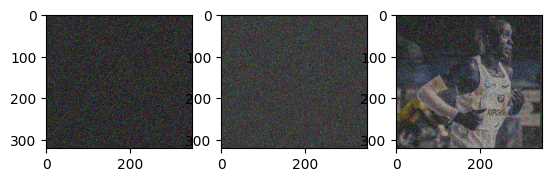

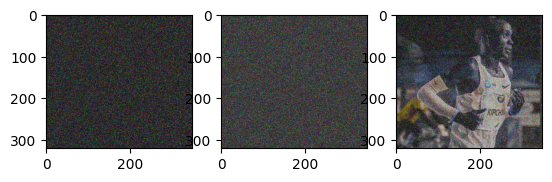

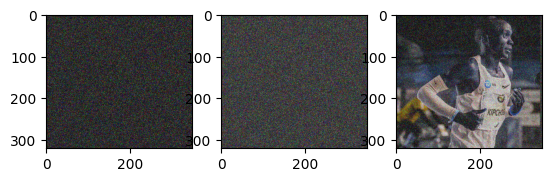

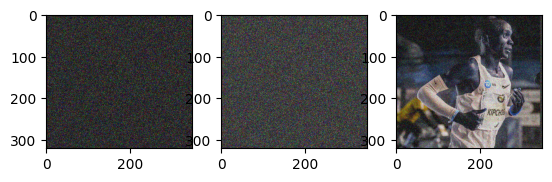

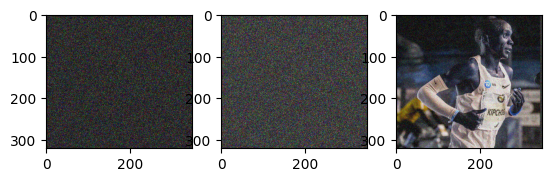

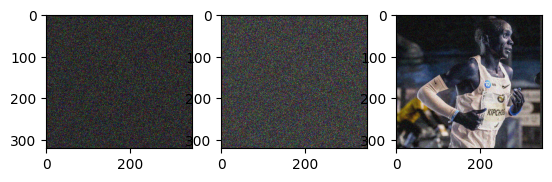

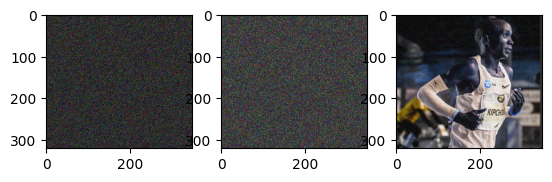

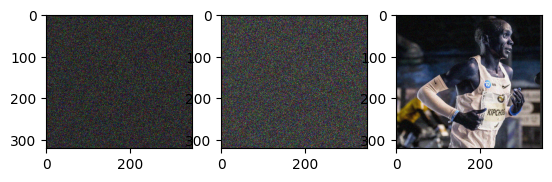

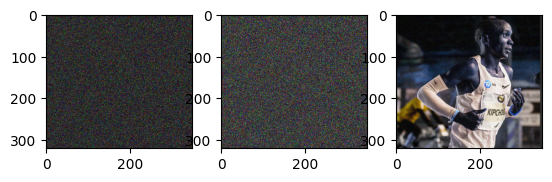

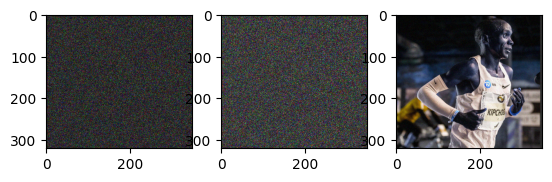

KeyboardInterrupt: ignored

In [83]:
jishu=-1
plt.figure(figsize=(6.4, 6.4))
for i in range(step):
  now_input=front[-1]
  image=[]
  for j in range(len(front)-1,0,-1):
    optimizer[j-1].zero_grad()
    now_input=now_input.to(device)
    mid_output=back[j-1](now_input)
    end_output=mid_output.reshape(320,350,3)
    ls=loss(front[j-1],end_output)
    ls.backward()
    nn.utils.clip_grad_norm_(back[j-1].parameters(),max_norm=2,norm_type=2)
    image.append(end_output.detach())
    optimizer[j-1].step()
    now_input=front[j-1].detach()
    optimizer[j-1].zero_grad()
    if jishu%100==0:
      #print(j)
      #print(mid_output)
      #print(ls)
      ;
  if jishu%400==0:
    plt.subplot(1,len(image)+1,1)
    plt.imshow(front[-1].to('cpu').numpy().astype(np.int32))
    for j in range(len(image)):
      plt.subplot(1,len(image)+1,j+2)
      plt.imshow(image[j].to('cpu').numpy().astype(np.int32))
    plt.show()
  jishu=jishu+1